In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from flask import Flask, render_template, request, url_for, redirect,jsonify,session
from werkzeug.utils import secure_filename
import json
from random import randint

In [2]:
filename_train="./dataset/training_set/"
filename_test="./dataset/testing_set/"
nbr_im=600

In [3]:
#resize a image from the dataset
img = cv2.imread('dataset/training_set/1.png')
img_resized = cv2.resize(img, dsize=(120,120), interpolation=cv2.INTER_CUBIC)
taille=img_resized.shape
print(taille)

(120, 120, 3)


In [4]:
def rgb2gray(I):
    r, g, b = I[:,:,0], I[:,:,1], I[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

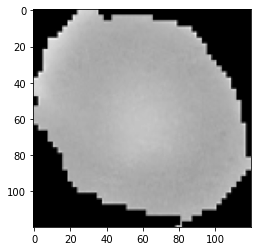

In [5]:
I_gray=rgb2gray(img_resized)
plt.imshow(I_gray,cmap=plt.get_cmap('gray')) #draws an image on the current figure (creates a figure if there isn't a current figure)
plt.show() #displays the figure

In [6]:
taille=I_gray.shape
taille
# nl,nc=taille

(120, 120)

In [7]:

def stocker_images(nbr_im, filename):
    nl,nc=taille
    mat_image=np.zeros((nl,nc,nbr_im))
    for i in range(nbr_im):
        target= filename+ str(i+1) + '.png'
        img = cv2.imread(target)
        img_resized = cv2.resize(img, dsize=(120,120), interpolation=cv2.INTER_CUBIC)
        mat_image[:,:,i]=rgb2gray(img_resized)       
    return mat_image

In [8]:
mat_train_image=stocker_images(nbr_im,filename_train)
mat_test_image=stocker_images(nbr_im,filename_test)

In [9]:
def dist(x,y):
    return np.sqrt(np.sum((x-y)**2))

In [10]:
def stock_dist(dist1,dist2,nbr_im):
    mat_dist=np.zeros((nbr_im,nbr_im))
    for i in range(0,nbr_im):
        for j in range(0,nbr_im):
            mat_dist[i,j]=dist(dist1[i],dist2[j])
    return mat_dist 

In [11]:
def convert_mat_index_binary(x):
    matrice=np.zeros((600,600))
    for i in range(600):
        if i>=0 and i<=299 :
            for j in range(0,600):
                if x[i][j]<=299:
                    matrice[i][j]=1
                else:
                    matrice[i][j]=0
        elif i>=300 and i<=599 :
             for j in range(0,600):
                if x[i][j]<=599 and x[i][j]>=300:
                    matrice[i][j]=1
                else:
                    matrice[i][j]=0 
    return matrice

In [12]:
def calc_evals(mat_dist_x):
    precision=np.zeros((1,600))
    recall=np.zeros((1,600))
    specificity=np.zeros((1,600))
    sensitivity=np.zeros((1,600))
    for i in range(1,601):
        VP=np.sum(mat_dist_x[0:i]) #sommer les valeurs positive du 0 jusqua i (exclus) dans la premiere ligne dans la matrice
        FP=i-VP
        FN=pertinent-VP
        VN=600-i-FN
        precision[0,i-1]=VP/(VP+FP)
        recall[0,i-1] =VP/(VP+FN)
        sensitivity[0,i-1]=VP/(VP+FN)
        specificity[0,i-1]=VN/(VN+FP)
    return precision,recall,sensitivity,specificity

In [13]:
def trace_evals(recall,precision):
    plt.grid(True)
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.plot(recall[0,:],precision[0,:],color="green")
    plt.show()

# histogramme

In [14]:
def histo(I):
    [nl,nc]=np.shape(I)
    h=np.zeros(256,dtype=int)
    I_m=np.round(I)
    for i in range(0,nl):
        for j in range(0,nc):
            val=int(I_m[i][j])
            h[val]+=1
    return h

In [15]:
def stocker_histogramme(mat_image):
    nl,nc,nb_im=mat_image.shape
    mat_histo=np.zeros((nb_im,256))
    for i in range(nb_im):
        mat_histo[i,:]=histo(mat_image[:,:,i])
    return mat_histo

In [16]:
mat_histo_testing=stocker_histogramme(mat_test_image)
mat_histo_training=stocker_histogramme(mat_train_image)

In [17]:
nbr_im=600
mat_dist_histo=stock_dist(mat_histo_testing,mat_histo_training,nbr_im)
mat_dist_histo

array([[2475.44420256, 2832.03107328, 2197.70334668, ..., 1771.75393325,
        2640.44011483, 2503.62696902],
       [1986.32726407, 2513.0045762 , 1695.47987307, ..., 1552.97456515,
        2109.47718641, 1838.30084589],
       [1569.17749155,  705.65997478, 1429.76501566, ..., 1281.80419722,
        1097.68756939, 1103.25427713],
       ...,
       [2619.74617091, 1163.87456369, 2338.84544167, ..., 2269.90704655,
        1548.9280164 , 1993.71913769],
       [2437.94831775, 1009.96336567, 2172.34849875, ..., 2062.50527272,
        1290.52237485, 1751.34062935],
       [1280.8942189 , 1709.93859539, 1275.55556523, ..., 1190.98530637,
        1307.81879479,  886.34756163]])

In [18]:
mat_index_histo=np.argsort(mat_dist_histo,axis=1)

In [19]:
new_mat_histo=convert_mat_index_binary(mat_index_histo)

In [20]:
#l'image requete est la premiere image du test(non infectée)
mat_dist_histo_non_Infectee=new_mat_histo[0,:]

#l'image requete est la premiere image du test (infectée)
mat_dist_histo_Infectee=new_mat_histo[300,:]


In [21]:
pertinent= np.sum(mat_dist_histo_non_Infectee)

pertinent= np.sum(mat_dist_histo_Infectee)


In [22]:
precision_nI_histo,recall_nI_histo,sensitivity_nI_histo,specificity_nI_histo= calc_evals(mat_dist_histo_non_Infectee)

In [23]:
precision_I_histo,recall_I_histo,sensitivity_I_histo,specificity_I_histo=calc_evals(mat_dist_histo_Infectee)

In [24]:
pr_moy_nI_histo=np.sum(precision_nI_histo[0,:])/precision_nI_histo[0,:].shape
print(pr_moy_nI_histo)

pr_moy_I_histo=np.sum(precision_I_histo[0,:])/precision_I_histo[0,:].shape
print(pr_moy_I_histo)

[0.27873631]
[0.6478107]


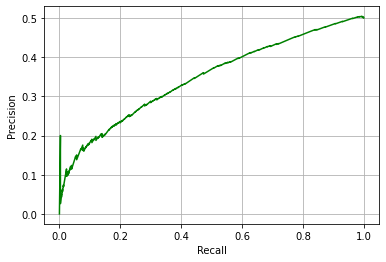

In [25]:
trace_evals(recall_nI_histo,precision_nI_histo)

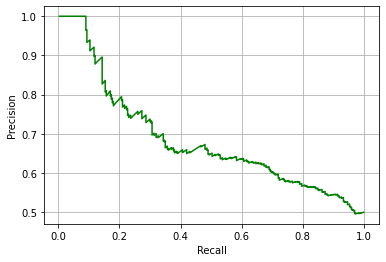

In [26]:
trace_evals(recall_I_histo,precision_I_histo)

# Texture

In [27]:
def variance2(I):
    nl,nc=I.shape
    m=np.mean(I)
    va=np.sum((I-m)**2)/(nl*nc)
    return va

In [28]:
def energie(I): 
    nl,nc=I.shape
    en= np.sum(I**2)
    return en

In [29]:
def entropie(I):
    ent=np.sum(I*np.log2(I+1e-10))
    return -ent

In [30]:
def contraste(I):
    nl,nc=I.shape
    co=0
    for i in range(nl):
        for j in range(nc):
            co+=((i-j)**2*I[i,j])
    return co

In [31]:
def homogenite(I):
    nl,nc=I.shape
    mo=0
    for i in range(nl):
        for j in range(nc):
            mo+=I[i,j]/(1+abs(i-j))
    return mo

In [32]:
def stocker_desc_txt(mat_image):
    nl,nc,nbr_img=mat_image.shape
    desc=np.zeros((nbr_img,5))
    for i in range(nbr_img) :
        I = mat_image[:,:,i]
        desc[i,:]=variance2(I), energie(I), entropie(I), contraste(I), homogenite(I)
    return desc

In [33]:
mat_desc_testing=stocker_desc_txt(mat_test_image)
mat_desc_training=stocker_desc_txt(mat_train_image)

In [34]:
nbr_im=600
mat_dist=stock_dist(mat_desc_testing,mat_desc_training,nbr_im)
mat_dist

array([[5.58740671e+08, 7.26951885e+08, 3.39637464e+08, ...,
        5.60085987e+08, 4.98641998e+08, 1.50962904e+08],
       [3.17277879e+07, 1.31007728e+09, 9.22551152e+08, ...,
        1.14322152e+09, 8.77464669e+07, 4.32332343e+08],
       [4.44823383e+08, 8.40760141e+08, 4.53445242e+08, ...,
        6.74126764e+08, 3.84593644e+08, 5.20702550e+07],
       ...,
       [1.33025546e+09, 4.72765542e+07, 4.33005926e+08, ...,
        2.12764820e+08, 1.27002710e+09, 9.23335739e+08],
       [8.55496769e+08, 4.29917435e+08, 4.53365754e+07, ...,
        2.63556677e+08, 7.95262676e+08, 4.49203362e+08],
       [3.67336585e+07, 1.26033116e+09, 8.72855194e+08, ...,
        1.09346629e+09, 4.53626806e+07, 3.82539565e+08]])

In [35]:
mat_index=np.argsort(mat_dist,axis=1)

In [36]:
new_mat=convert_mat_index_binary(mat_index)

In [37]:
#l'image requete est la premiere image du test(non infectée)
mat_dist_non_Infectee=new_mat[0,:]

#l'image requete est la premiere image du test (infectée)
mat_dist_Infectee=new_mat[300,:]


In [38]:
pertinent= np.sum(mat_dist_non_Infectee)

pertinent= np.sum(mat_dist_Infectee)


In [39]:
precision_nI,recall_nI,sensitivity_nI,specificity_nI=calc_evals(mat_dist_non_Infectee)

In [40]:
precision_I,recall_I,sensitivity_I,specificity_I=calc_evals(mat_dist_Infectee)

In [41]:
pr_moy_nI=np.sum(precision_nI[0,:])/precision_nI[0,:].shape
print(pr_moy_nI)

pr_moy_I=np.sum(precision_I[0,:])/precision_I[0,:].shape
print(pr_moy_I)

[0.42678847]
[0.52862887]


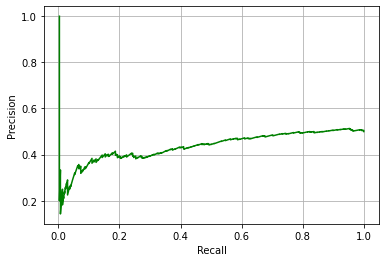

In [42]:
trace_evals(recall_nI,precision_nI)

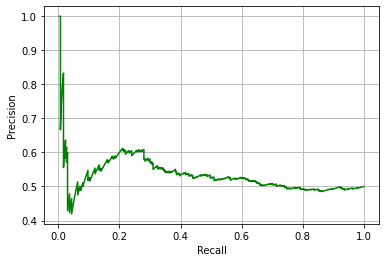

In [43]:
trace_evals(recall_I,precision_I)

# forme & histogramme

In [44]:
def Laplacian(I):
    img_lap=cv2.Laplacian(I,cv2.CV_8U,-1)
    r, g, b = img_lap[:,:,0], img_lap[:,:,1], img_lap[:,:,2]
    gray_lap= 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray_lap

In [45]:
def stocker_images_forme(nbr_im, filename):
    nl,nc=taille
    mat_image=np.zeros((nl,nc,nbr_im))
    for i in range(nbr_im):
        target= filename+ str(i+1) + '.png'
        img = cv2.imread(target)
        img_resized = cv2.resize(img, dsize=(120,120), interpolation=cv2.INTER_CUBIC)
        mat_image[:,:,i]=Laplacian(img_resized)      
    return mat_image

In [46]:
mat_train_image_f=stocker_images_forme(nbr_im,filename_train)
mat_test_image_f=stocker_images_forme(nbr_im,filename_test)

In [47]:
mat_desc_testing_f=stocker_histogramme(mat_test_image_f)
mat_desc_training_f=stocker_histogramme(mat_train_image_f)

In [48]:
nbr_im=600
mat_dist_f=stock_dist(mat_desc_testing_f,mat_desc_training_f,nbr_im)
mat_dist_f

array([[ 465.18383463,  830.86220277,  528.41082502, ..., 1627.0427161 ,
         902.68931532,  891.82285236],
       [ 541.09888191,  766.65898547,  652.33273718, ..., 1871.43474372,
         929.10279302,  775.33863569],
       [ 645.60978927,  940.35418859,  738.67178097, ..., 1901.36582487,
        1066.03752279,  958.40075125],
       ...,
       [ 390.7633555 ,  293.87412271,  324.05246489, ..., 1129.25373588,
         218.40787532,  417.54760208],
       [ 564.36335813,  502.39625795,  471.2112053 , ...,  929.54289842,
         302.15227949,  586.16891763],
       [ 315.82906769,  364.98767102,  314.37239065, ..., 1195.84614395,
         302.57230541,  389.59209438]])

In [49]:
mat_index_f=np.argsort(mat_dist_f,axis=1)

In [50]:
new_mat_f=convert_mat_index_binary(mat_index_f)

In [51]:
#l'image requete est la premiere image du test(non infectée)
mat_dist_f_non_Infectee=new_mat_f[0,:]

#l'image requete est la premiere image du test (infectée)
mat_dist_f_Infectee=new_mat_f[300,:]

In [52]:
pertinent= np.sum(mat_dist_f_non_Infectee)

pertinent= np.sum(mat_dist_f_Infectee)


In [53]:
precision_nI_f,recall_nI_f,sensitivity_nI_f,specificity_nI_f=calc_evals(mat_dist_f_non_Infectee)

In [54]:
precision_I_f,recall_I_f,sensitivity_I_f,specificity_I_f=calc_evals(mat_dist_f_Infectee)

In [55]:
pr_moy_nI_f=np.sum(precision_nI_f[0,:])/precision_nI_f[0,:].shape
print(pr_moy_nI_f)

pr_moy_I_f=np.sum(precision_I_f[0,:])/precision_I_f[0,:].shape
print(pr_moy_I_f)

[0.51096986]
[0.5434618]


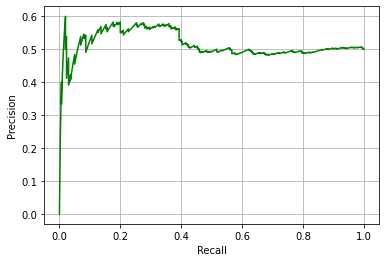

In [56]:
trace_evals(recall_nI_f,precision_nI_f)

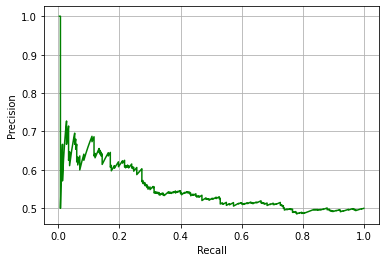

In [57]:
trace_evals(recall_I_f,precision_I_f)

# Algorithme K plus proches

In [58]:
def determiner_KNN_images(index_img_requete,nbr_img_recuperes,descripteur):
    if int(descripteur)==1 :
        matrice1=mat_index_histo
        matrice2=new_mat_histo
    elif int(descripteur)==2:
        matrice1=mat_index
        matrice2=new_mat
    elif int(descripteur)==3:
        matrice1=mat_index_f
        matrice2=new_mat_f
        
    matrice_dest=matrice1[index_img_requete,:]
    mat_index_proches=matrice_dest[0:nbr_img_recuperes] #les indices k plus proches
    per=np.sum(matrice2[index_image,:])
    x=matrice2[index_image,0:nbr_img_recuperes]
    k=1
    
    for i in mat_index_proches:
        target=filename_train + str(i) +".png"
        pic=plt.imread(target)
        plt.subplot(2,4,k)
        if i>0 and i<300:
            img_status='Non infectée'
            plt.title(img_status)
        elif i>=300 and i<600:
            img_status="Infectée"
            plt.title(img_status)
        plt.imshow(pic)
        k=k+1
        
    per=np.sum(matrice2[index_image,:])
    x=matrice2[index_image,0:nbr_img_recuperes]
    vp=np.sum(x)
    print('VP :',vp)
    fp=nbr_img_recuperes-vp
    print('FP :',fp)
    fn=per-vp
    print('FN :',fn)
    vn=600-nbr_img_recuperes-fn
    print('VN :',vn)
    precis=vp/(vp+fp)
    print('la précision :',precis*100,"%")
    reca=vp/(vp+fn)
    print('le rappel :',reca*100,"%")
    spec=vn/(vn+fp)
    print('la spécificité :',spec*100,"%")
    sens=vp/(vp+fn)
    print('la sensitivité :',sens*100,"%")
    acc=(vp+vn)/(vp+vn+fp+fn)
    print('Accuracy :',acc*100,"%")
    f1=(2*precis*reca)/(precis+reca)
    print('F1-score :',f1*100,"%")

donner le numero d'image:	280
donner le nombre des images plus proches:	8
	 saisie :
 1-histogramme  /  2-texture  /  3-Form	1


VP : 5.0
FP : 3.0
FN : 295.0
VN : 297.0
la précision : 62.5 %
le rappel : 1.6666666666666667 %
la spécificité : 99.0 %
la sensitivité : 1.6666666666666667 %
Accuracy : 50.33333333333333 %
F1-score : 3.2467532467532463 %


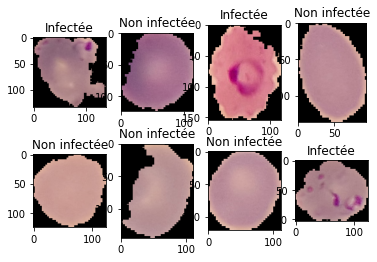

In [59]:
index_image=int(input("donner le numero d'image:\t"))
nbr_img_recuperes=int(input("donner le nombre des images plus proches:\t"))
descripteur=int(input("\t saisie :\n 1-histogramme  /  2-texture  /  3-Form\t"))
print('\n')
determiner_KNN_images(index_image,nbr_img_recuperes,descripteur)

# App web avec flask

In [62]:

def calc_measurs(index_img_requete,mat_index_desc,mat_binary,nbr_img_recuperes=8):
    eval_params={}
    matrice_dest=mat_index_desc[index_img_requete,:]
    mat_index_proches=matrice_dest[0:nbr_img_recuperes] #les indices k plus proches
    image_url=''
    value=randint(0,10000)
    k=1
    for i in mat_index_proches:
        target=filename_train + str(i) +".png"
        pic=plt.imread(target)
        plt.subplot(2,4,k)
        if i>0 and i<300:
            img_status='Non infectée'
            plt.title(img_status)
        elif i>=300 and i<600:
            img_status="Infectée"
            plt.title(img_status)
        plt.imshow(pic)
        plt.savefig('static/img/' + str(value) + '.png')
        image_url = str(value) + '.png'
        k=k+1    
    per=np.sum(mat_binary[index_img_requete,:])
    mat_binary_requete=mat_binary[index_img_requete,0:nbr_img_recuperes]
    vp=np.sum(mat_binary_requete) #vrais postives
    fp=nbr_img_recuperes-vp  #faux positives
    fn=per-vp #faux negatives
    vn=600-nbr_img_recuperes-fn # vrais negatives
    eval_params['precision']=vp*100/(vp+fp)
    eval_params['rappel']=vp*100/(vp+fn)
    eval_params['sensitivity']=vp*100/(vp+fn)
    eval_params['specificity']=vn*100/(vn+fp)
    eval_params['f1_score']= 2*vp*100 / (2*vp + fp + fn)
    eval_params['accuracy']=(vp+vn)*100/(vp+vn+fp+fn)
    eval_params['image_url']=image_url
    return eval_params

In [ ]:

app = Flask(__name__)
UPLOAD_FOLDER = 'static/uploads'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
app.config['MAX_CONTENT_LENGTH'] = 16 * 1024 * 1024
ALLOWED_EXTENSIONS = set(['png', 'jpg', 'jpeg', 'gif'])
eval_params={}
def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS


@app.route('/')
def home():
    return render_template('home.html',)


@app.route('/upload', methods=['POST','GET'])
def upload():
    if request.method == 'POST':
        file = request.files['file']
        filename = secure_filename(file.filename)
        file_name = filename.split(".")
        print(file_name)
        index = int(file_name[0])
        eval_params_histo=calc_measurs(index,mat_index_histo,new_mat_histo)
        eval_params_texture=calc_measurs(index,mat_index,new_mat)
        eval_params_form=calc_measurs(index,mat_index_f,new_mat_f)
        print(eval_params_histo)
        print(eval_params_texture)
        file.save(os.path.join(app.config['UPLOAD_FOLDER'], filename))
        return jsonify(eval_params_histo,eval_params_texture,eval_params_form)
if __name__ == '__main__':
    app.run()


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [15/Mar/2021 23:35:21] "GET / HTTP/1.1" 200 -


['280', 'png']


C:\ProgramData\Anaconda3\envs\mini-projet\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
127.0.0.1 - - [15/Mar/2021 23:36:14] "POST /upload HTTP/1.1" 200 -
127.0.0.1 - - [15/Mar/2021 23:36:14] "GET /static/img/1949.png HTTP/1.1" 200 -
127.0.0.1 - - [15/Mar/2021 23:36:14] "GET /static/img/5890.png HTTP/1.1" 200 -
127.0.0.1 - - [15/Mar/2021 23:36:14] "GET /static/img/9703.png HTTP/1.1" 200 -


{'precision': 62.5, 'rappel': 1.6666666666666667, 'sensitivity': 1.6666666666666667, 'specificity': 99.0, 'f1_score': 3.2467532467532467, 'accuracy': 50.333333333333336, 'image_url': '1949.png'}
{'precision': 75.0, 'rappel': 2.0, 'sensitivity': 2.0, 'specificity': 99.33333333333333, 'f1_score': 3.896103896103896, 'accuracy': 50.666666666666664, 'image_url': '5890.png'}
